导入需要的库

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score,roc_curve, auc,RocCurveDisplay
from sklearn.feature_selection import RFECV
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体为黑体
plt.rcParams['axes.unicode_minus'] = False    # 正确显示负号

对数据的预处理：完成了数据的基础预处理。首先读取原始数据文件，去除无用的“Unnamed: 32”列。然后将“diagnosis”列（肿瘤良恶性）映射为0/1标签，便于后续建模。最后将数据集划分为训练集和测试集。

In [22]:
#  读取数据
data = pd.read_csv('data.csv')
data.drop(columns=["Unnamed: 32"], inplace=True)

#  特征与标签
X = data.drop(columns=['diagnosis'])
y = data['diagnosis'].map({'M': 1, 'B': 0})  # M=恶性=1, B=良性=0

#  划分训练与测试集（避免数据泄漏）
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


特征选择：使用递归特征消除与交叉验证（RFECV）方法，自动在训练集上选择最优特征子集，提升模型泛化能力。通过可视化展示不同特征数量下模型的交叉验证准确率，帮助理解特征选择过程。随后对筛选后的特征进行标准化处理，使各特征具有相同的尺度，避免特征量纲影响模型表现。标准化后的数据将用于后续模型训练和交叉验证

最佳特征数：19
选择的特征： ['id', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'concavity_mean', 'concave points_mean', 'radius_se', 'area_se', 'concavity_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst']


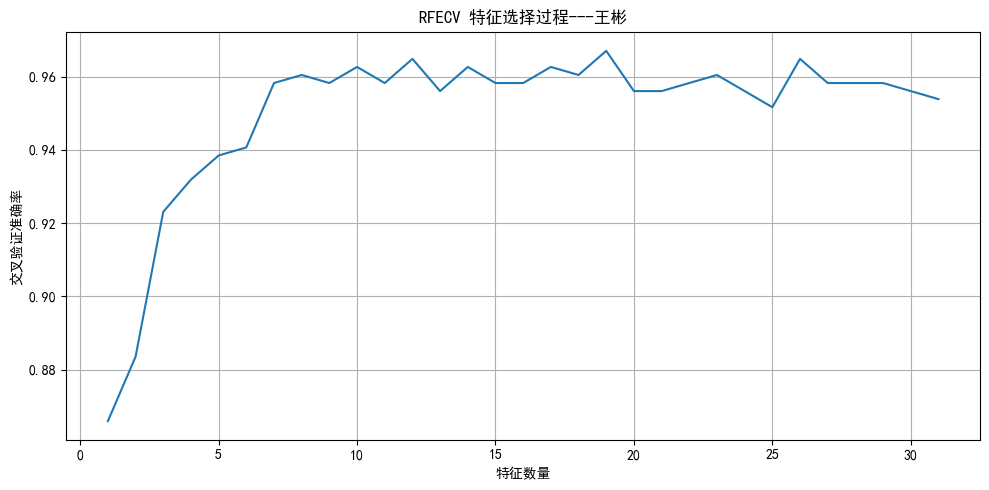

In [ ]:
# 训练集特征选择
estimator = RandomForestClassifier(n_estimators=100, random_state=42)
selector = RFECV(estimator, step=1, cv=5, scoring='accuracy')
selector.fit(X_train_raw, y_train)

selected_features = X_train_raw.columns[selector.support_]
print(f"最佳特征数：{selector.n_features_}")
print("选择的特征：", list(selected_features))

X_train_selected = X_train_raw[selected_features]
X_test_selected = X_test_raw[selected_features]

#  可视化特征选择过程
plt.figure(figsize=(10, 5))
plt.title("RFECV 特征选择过程---王彬")
plt.xlabel("特征数量")
plt.ylabel("交叉验证准确率")
plt.plot(
    range(1, len(selector.cv_results_['mean_test_score']) + 1),
    selector.cv_results_['mean_test_score']
)
plt.grid(True)
plt.tight_layout()
plt.show()

#  特征标准化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_selected)
X_test = scaler.transform(X_test_selected)
X_scaled = scaler.fit_transform(X[selected_features])  # 用于交叉验证全数据

Stcaking模型的构建及调参：对随机森林和支持向量机（SVM）进行网格搜索调参，自动寻找最优超参数组合。然后将调优后的模型与逻辑回归、XGBoost等基学习器一起，构建Stacking集成模型。Stacking通过多模型融合提升整体预测性能，最终由逻辑回归作为元学习器进行二次学习

In [24]:
# === 1. 随机森林调参 ===
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_
print("随机森林最优参数:", grid_rf.best_params_)

# === 2. 支持向量机调参 ===
svm_param_grid = {
    'C': [1, 10],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf', 'linear']
}
grid_svm = GridSearchCV(SVC(probability=True), svm_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_svm.fit(X_train, y_train)
best_svm = grid_svm.best_estimator_
print("SVM 最优参数:", grid_svm.best_params_)

# === 3. XGBoost 调参 ===
xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1]
}
grid_xgb = GridSearchCV(
    xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    xgb_param_grid, cv=5, scoring='accuracy', n_jobs=-1
)
grid_xgb.fit(X_train, y_train)
best_xgb = grid_xgb.best_estimator_
print("XGBoost 最优参数:", grid_xgb.best_params_)


# === 4. 构建 Stacking 模型 ===
base_models = [
    ('lr', LogisticRegression(max_iter=1000)),
    ('svm', best_svm),
    ('rf', best_rf),
    ('xgb', best_xgb),
]
meta_model = LogisticRegression()

stack_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1
)

随机森林最优参数: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
SVM 最优参数: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
XGBoost 最优参数: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}


基于Stacking集成学习方法构建乳腺癌分类模型，首先在训练集上完成模型训练，并在测试集上进行预测与性能评估。通过输出详细的分类报告、混淆矩阵及AUC分数，全面反映了模型在区分良性与恶性肿瘤上的能力。其中，混淆矩阵直观展现了模型在不同类别上的预测准确性与错误情况。为了进一步验证模型的稳定性与泛化能力，采用5折交叉验证方法，在每一折中分别输出分类结果，并绘制平均ROC曲线，评估模型在不同决策阈值下的表现。交叉验证所得准确率与平均AUC表明，Stacking模型在多次数据划分中均能保持较高的识别效果，具有良好的鲁棒性和临床应用潜力。


第 1 折交叉验证 - 分类报告：
              precision    recall  f1-score   support

      Benign   1.000000  0.985915  0.992908        71
   Malignant   0.977273  1.000000  0.988506        43

    accuracy                       0.991228       114
   macro avg   0.988636  0.992958  0.990707       114
weighted avg   0.991427  0.991228  0.991247       114

混淆矩阵：
[[70  1]
 [ 0 43]]

第 2 折交叉验证 - 分类报告：
              precision    recall  f1-score   support

      Benign   0.934211  1.000000  0.965986        71
   Malignant   1.000000  0.883721  0.938272        43

    accuracy                       0.956140       114
   macro avg   0.967105  0.941860  0.952129       114
weighted avg   0.959026  0.956140  0.955533       114

混淆矩阵：
[[71  0]
 [ 5 38]]

第 3 折交叉验证 - 分类报告：
              precision    recall  f1-score   support

      Benign   0.960000  1.000000  0.979592        72
   Malignant   1.000000  0.928571  0.962963        42

    accuracy                       0.973684       114
   macro avg   0.9800

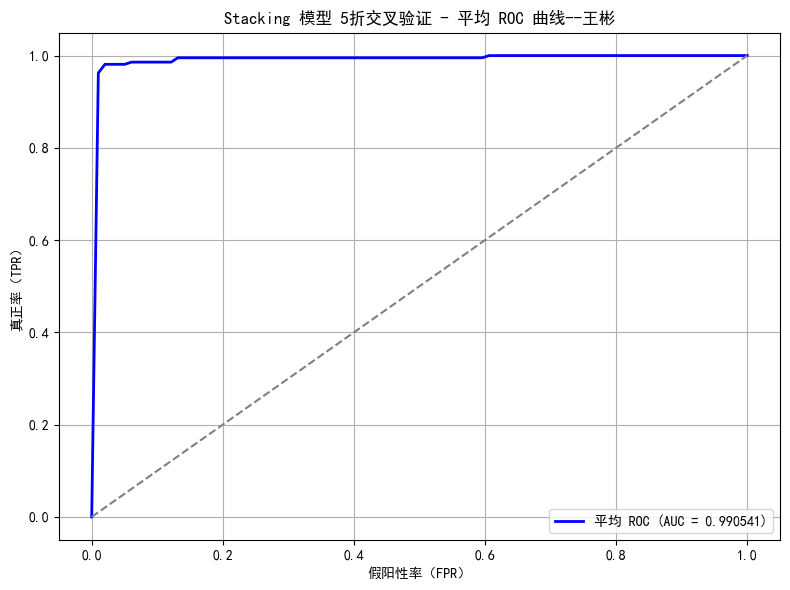

In [25]:

# 训练 Stacking 模型
stack_model.fit(X_train, y_train)

np.set_printoptions(precision=6, suppress=True)  

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

all_y_true = []
all_y_pred = []

# 用于平均 ROC
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

for i, (train_idx, test_idx) in enumerate(cv.split(X_scaled, y)):
    X_cv_train, X_cv_test = X_scaled[train_idx], X_scaled[test_idx]
    y_cv_train, y_cv_test = y[train_idx], y[test_idx]

    stack_model.fit(X_cv_train, y_cv_train)
    y_cv_pred = stack_model.predict(X_cv_test)
    y_cv_prob = stack_model.predict_proba(X_cv_test)[:, 1]

    all_y_true.extend(y_cv_test)
    all_y_pred.extend(y_cv_pred)

    # 打印当前折的分类报告（保留6位小数）
    print(f"\n第 {i+1} 折交叉验证 - 分类报告：")
    print(classification_report(y_cv_test, y_cv_pred, target_names=["Benign", "Malignant"], digits=6))

    # 打印当前折的混淆矩阵
    cm = confusion_matrix(y_cv_test, y_cv_pred)
    print("混淆矩阵：")
    print(cm)

    # ROC 曲线数据
    fpr, tpr, _ = roc_curve(y_cv_test, y_cv_prob)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(auc(fpr, tpr))

# 整体交叉验证下的分类报告
print("\n【整体交叉验证结果】")
print("总体分类报告：")
print(classification_report(all_y_true, all_y_pred, target_names=["良性（B）", "恶性（M）"], digits=6))

# 绘制平均 ROC 曲线
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.figure(figsize=(8, 6))
plt.plot(mean_fpr, mean_tpr, color='blue', label=f'平均 ROC (AUC = {mean_auc:.6f})', lw=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title("Stacking 模型 5折交叉验证 - 平均 ROC 曲线--王彬")
plt.xlabel('假阳性率（FPR）')
plt.ylabel('真正率（TPR）')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()